In [1]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
bitcoin_data = pd.read_csv('BTC-USDT-1h.csv')
bitcoin_data.drop(columns = ['close_time','quote_asset_volume','number_of_trades','taker_buy_base_asset_volume','taker_buy_quote_asset_volume','ignore'],inplace=True)
bitcoin_data['open_time'] = pd.to_datetime(bitcoin_data['open_time'],unit='ms').astype('str')

In [3]:
bitcoin_data.shape

(43879, 6)

In [4]:
data_training = bitcoin_data[bitcoin_data['open_time']< '2021-01-01'].copy()
data_test = bitcoin_data[bitcoin_data['open_time']> '2021-01-01'].copy()
training_data = data_training.drop(['open_time'], axis = 1)

In [5]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)

In [6]:
X_train = [] 
Y_train = []
training_data.shape[0]
for i in range(60, training_data.shape[0]):
 X_train.append(training_data[i-60:i])
 Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(29415, 60, 5)

In [7]:
with tf.device('gpu'):
    model = Sequential() 
    model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
    model.add(Dropout(0.2)) 
    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.3)) 
    model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.4)) 
    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units =1))
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [8]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [9]:
history= model.fit(X_train, Y_train, epochs = 20, batch_size =500, validation_split=0.1)

Epoch 1/20
53/53 [==============================] - 41s 688ms/step - loss: 0.0067 - val_loss: 0.0034
Epoch 2/20
53/53 [==============================] - 35s 661ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/20
53/53 [==============================] - 34s 651ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 4/20
53/53 [==============================] - 35s 665ms/step - loss: 9.7031e-04 - val_loss: 0.0046
Epoch 5/20
53/53 [==============================] - 36s 674ms/step - loss: 9.0154e-04 - val_loss: 0.0045
Epoch 6/20
53/53 [==============================] - 35s 664ms/step - loss: 7.8842e-04 - val_loss: 0.0063
Epoch 7/20
53/53 [==============================] - 35s 656ms/step - loss: 7.6980e-04 - val_loss: 0.0049
Epoch 8/20
53/53 [==============================] - 35s 668ms/step - loss: 6.9722e-04 - val_loss: 0.0059
Epoch 9/20
53/53 [==============================] - 35s 669ms/step - loss: 6.6908e-04 - val_loss: 0.0051
Epoch 10/20
53/53 [==============================] - 35s 666ms/step

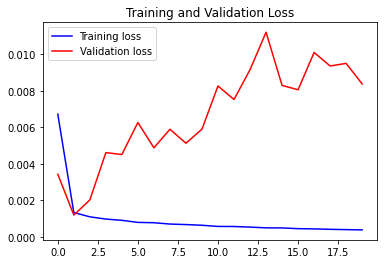

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [18]:
part_60_days = data_training.tail(60)
df= part_60_days.append(data_test, ignore_index = True)
df = df.drop(['open_time'], axis = 1)
df.head()

C:\Users\gampa\AppData\Local\Temp\ipykernel_6360\2070271018.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df= part_60_days.append(data_test, ignore_index = True)


,open,high,low,close,volume
0,26874.55,27100.00,26858.51,26893.22,3680.930227
1,26893.22,26977.16,26730.00,26880.00,2050.083026
2,26880.01,26902.22,26600.65,26664.49,2589.537729
3,26664.49,26734.40,26433.00,26614.97,2674.218288
4,26615.28,26625.99,26204.99,26430.84,4570.551340


In [19]:
inputs = scaler.transform(df)

In [20]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])
X_test, Y_test = np.array(X_test), np.array(Y_test) 
Y_pred = model.predict(X_test)

451/451 [==============================] - 30s 66ms/step


In [21]:
Y_pred, Y_test
scaler.scale_

array([3.80454674e-05, 3.79506641e-05, 3.82509084e-05, 3.81152032e-05,
       2.11614403e-05])

In [22]:
scale = scaler.scale_[0]
Y_test = Y_test*scale 
Y_pred = Y_pred*scale
Y_pred

array([[2.7646302e-05],
       [2.7746300e-05],
       [2.7875874e-05],
       ...,
       [2.1404358e-05],
       [2.1363145e-05],
       [2.1328113e-05]], dtype=float32)

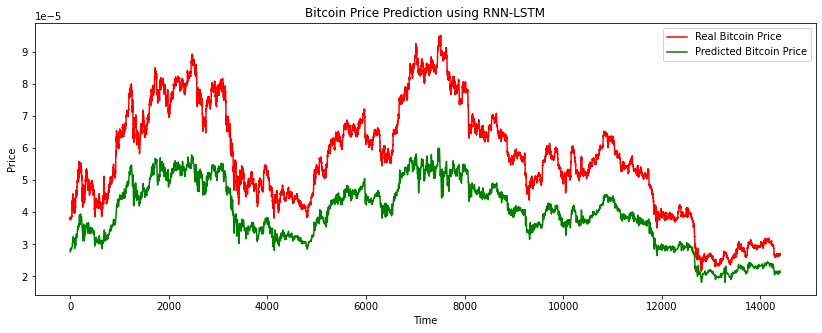

In [16]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()